#Data matching problem for SED assignment

## High level overview

__Data set 1__ will be a cosmological simulation of galaxy properties. The exact list of properties included will vary depending on the simulation, and also over time as simulations improve and perhaps output more quantities. At a minimum for any simulation we expect:
* rest-frame magnitudes in a set of bandpasses (LSST+potentially others outside of the optical wavelength region)
* observed-frame magnitudes in the same bandpasses
* redshift

Most simulations will have properties that allow (at least a crude) reconstruction of the spectrum of the simulated galaxy (e.g. from having rest-frame magnitudes in many very narrow bandpasses). Some simulations will also have properties that relate more directly to the physical description of the galaxy, e.g. its stellar mass, star formation rate, metallicity, also perhaps its shape or morphology. We would like any solution for our data matching problem to be extensible to incorporating more properties of the simulated galaxy than simply a set of magnitudes (or equivalently colors) or a crude representation of its spectrum.


__Data set 2__ will be a set of discrete galaxy spectra, where a spectrum is just a list of flux values at some grid of wavelengths (not necessarily evenly spaced or the same grid for every galaxy in the set). We assume here (or at least hope!) that this set of galaxy spectra span the range of galaxy types in the real universe, however since it is a discrete set it is only sampling the range of galaxy types in the real universe. 

For the __data matching__ we wish to assign a galaxy spectrum drawn from the distribution of discrete galaxy spectra in __data set 2__ onto a galaxy from the simulation in __data set 1__. Immediately two problems are evident: how to turn the discrete set of galaxy spectra in __data set 2__ into a continous distribution to draw from? And, how to define a relation between a galaxy spectrum in __data set 2__ to a set of galaxy properties in __data set 1__?

*Note we may use the terms spectrum, SED and template interchangeabley, but they are generally all the same thing. "Library" is often used to mean a set of galaxy template spectra*

## Overview of some current galaxy simulation data sets

### Galacticus
The data read in below is from a simulation using the Galacticus simulation tool run by Eve Kovacs. The simulation included magnitudes in a set of narrow band top hat filters evenly spaced in log wavelengths (I think so that d$\lambda$/$\lambda$=10). 

To convert the magnitudes $m$ in each filter into fluxes (in the right units, i.e. wavelength units, $ f_\lambda$) the following was done:

$ f_\lambda = 10^{-0.4m}/\lambda^2 $

where $\lambda$ is the central wavelength of the filter

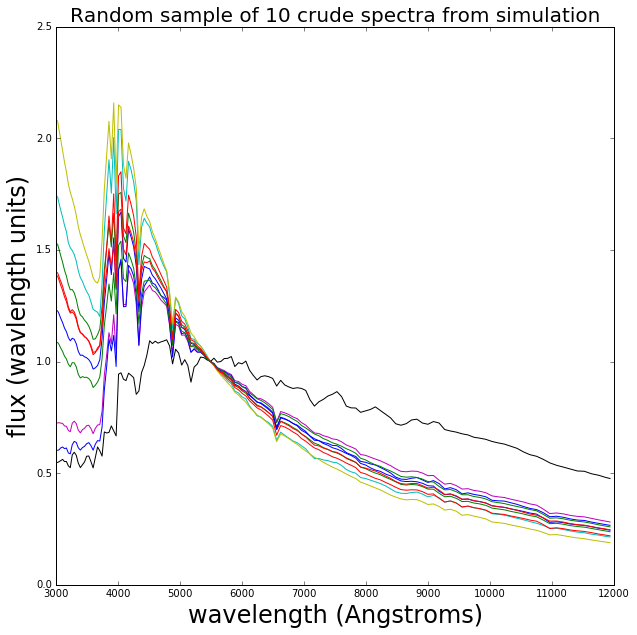

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# files created by Matias CK: simulation data in narrow band magnitudes that has been
# converted to fluxes
wavelength_grid = np.loadtxt('wave.txt')   # grid of wavelengths fluxes are defined at
sim_data = np.loadtxt('degraded_sims.txt') # fluxes of each 17k simulation galaxies

# randomly pick 10 and plot them
ipick = np.random.randint(0, len(sim_data), size=(10,))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in ipick:
    ax.plot(wavelength_grid, sim_data[i,:])
ax.set_xlabel('wavelength (Angstroms)', fontsize=24)
ax.set_ylabel('flux (wavlength units)', fontsize=24)
ax.set_title('Random sample of 10 crude spectra from simulation', fontsize=20)



### Buzzard

TBD



## Galaxy spectra set

We focus on using the "Brown template spectra", but ultimately we could use any discrete set of galaxy spectra. The Brown template spectra are described in this [paper](http://arxiv.org/abs/1312.3029) where real observations (both spectra and photometry) of galaxies were used to constrain each galaxy's spectrum over a broad wavelength range spanning from the UV to the mid-IR and are thought to provide a better match to real observations of galaxies.

There are 129 galaxies in this set of spectra. From plotting 10 at random below you can already see that there are probably a lot more "red" galaxies (less flux at smaller wavelengths) than "blue" galaxies as compared to the Galacticus simulation.

The data for the Brown spectra below has been degraded to the same resolution as the Galacticus simulation data above. Also emission lines in the spectra have been removed.

(129, 141)


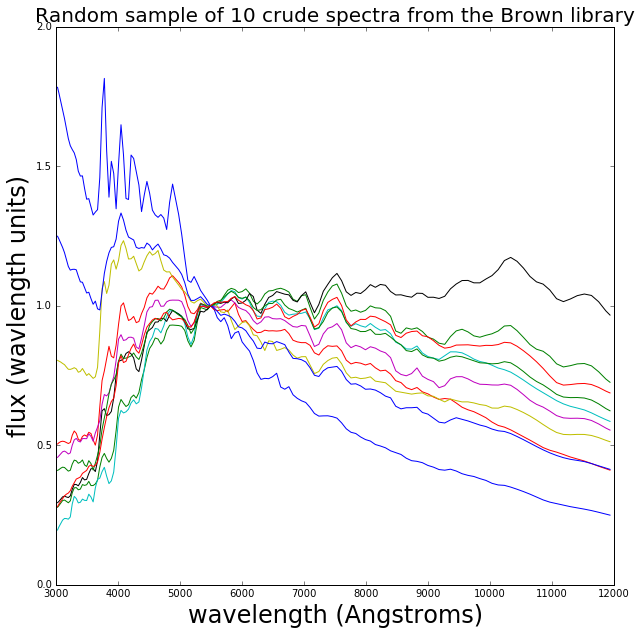

In [14]:
# Data file made by Matias CK
sed_data = np.loadtxt('degraded_brown.txt') # 129

# randomly pick 10 and plot them
ipick = np.random.randint(0, len(sed_data), size=(10,))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in ipick:
    ax.plot(wavelength_grid, sed_data[i,:])
ax.set_xlabel('wavelength (Angstroms)', fontsize=24)
ax.set_ylabel('flux (wavlength units)', fontsize=24)
ax.set_title('Random sample of 10 crude spectra from the Brown library', fontsize=20)


## Demonstration of some issues

A nice method of projecting our template spectra into PCA space and then training a relationship between the first $N$ principal components and galaxy color is described [here](https://github.com/jbkalmbach/spectraPCA/blob/master/examples/PCA_on_kurucz_library.ipynb) implemented by Bryce Kalmback (though for stars, see underneath the sub-heading "Deriving Principal Components for Catalog Objects").

Initially we thought we could implement something like this to simultaneously define a continuous distribution of galaxies from our discrete template set, and to map one of these "continous" SEDs onto a simulated galaxy according to its color (based upon a trained relation between color and $N$ principal components).

(17242, 141)


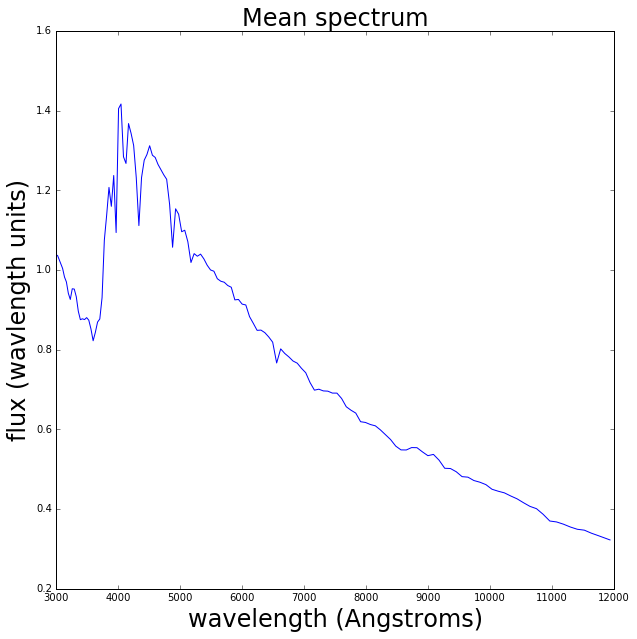

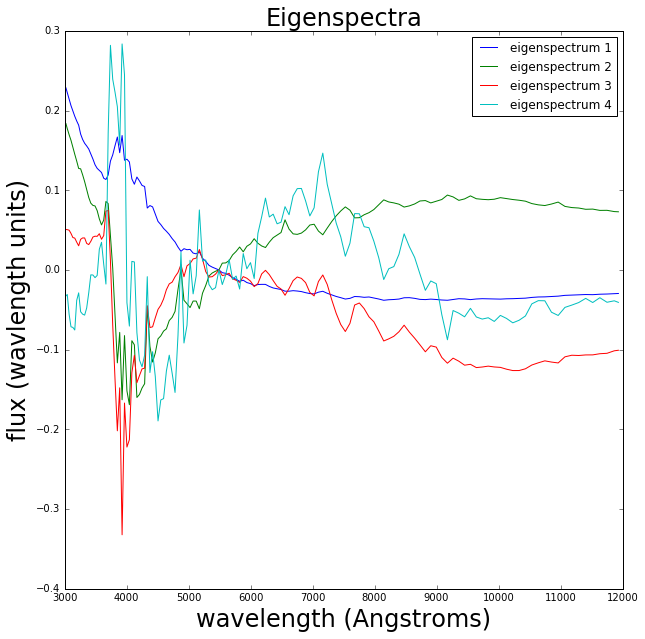

In [24]:
# concatenate the data matrices together
X = np.concatenate((sed_data,sim_data))
print X.shape

# Do PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(X)
mean_spectrum = pca.mean_
eigenspectra = pca.components_
eigenvalue_coeffs = np.array(pca.transform(X))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(wavelength_grid, mean_spectrum)
ax.set_xlabel('wavelength (Angstroms)', fontsize=24)
ax.set_ylabel('flux (wavlength units)', fontsize=24)
ax.set_title('Mean spectrum', fontsize=24)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(wavelength_grid, eigenspectra[0,:], label='eigenspectrum 1')
ax.plot(wavelength_grid, eigenspectra[1,:], label='eigenspectrum 2')
ax.plot(wavelength_grid, eigenspectra[2,:], label='eigenspectrum 3')
ax.plot(wavelength_grid, eigenspectra[3,:], label='eigenspectrum 4')
ax.set_xlabel('wavelength (Angstroms)', fontsize=24)
ax.set_ylabel('flux (wavlength units)', fontsize=24)
ax.set_title('Eigenspectra', fontsize=24)
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels, loc='upper right', prop={'size':12})

From the first few eigenspectra you can already see why the first and second eigenspectra are the ones that are most sensitive to color.

11
11


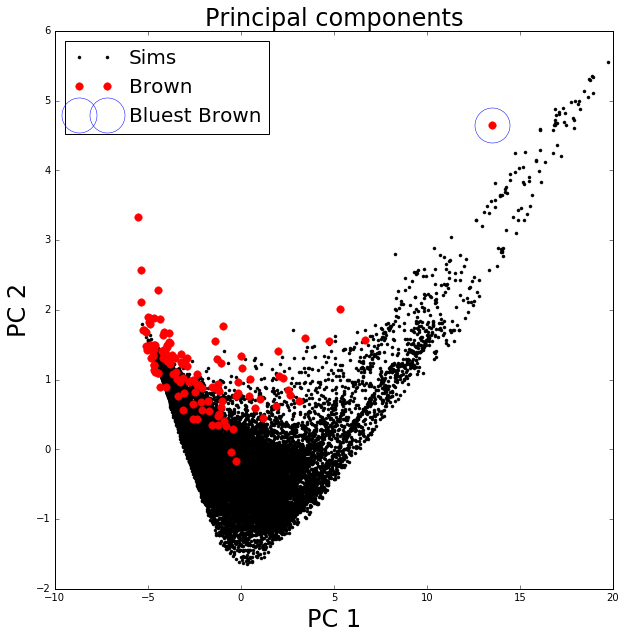

In [42]:
ibluest_brown = np.argmax(eigenvalue_coeffs[:129,0])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(eigenvalue_coeffs[129:,0], eigenvalue_coeffs[129:,1], linestyle='none', 
        marker='.', color='black', label='Sims')
ax.plot(eigenvalue_coeffs[:129,0], eigenvalue_coeffs[:129,1], linestyle='none', 
        marker='.', color='red', markersize=15, label='Brown')
ax.plot(eigenvalue_coeffs[ibluest_brown,0], eigenvalue_coeffs[ibluest_brown,1], linestyle='none', 
        marker='o', markerfacecolor='none', markeredgecolor='blue', markersize=35, 
        label='Bluest Brown')
ax.set_xlabel('PC 1', fontsize=24)
ax.set_ylabel('PC 2', fontsize=24)
ax.set_title('Principal components', fontsize=24)
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels, loc='upper left', prop={'size':20})

print np.argmax(eigenvalue_coeffs[:129,0])
print np.argmax(eigenvalue_coeffs[:129,1])

### Issues
As demoed in PCA-space shown above, the Brown templates and the simulation galaxies don't quite lie within the same space. This is where we think the diffusion maps with landmarks could become a helpful solution. We need to assign a simulation galaxy with a spectrum drawn from the Brown templates that has some reasonable physical relationship to the original simulated galaxy. And this is where the PCA technique can fail catastrophically: if few Brown spectra live in the regions covered by the simulation galaxies, any Brown driven PC's assigned to a simulated galaxy far outside their region will produce a spectrum that has little or no relation to the original simulated galaxy. (this also may be a consequence that PCA can't deal with nonlinear relationships between data points).

Also there is a lack of sampling in the Brown templates of bluer galaxies indicated by the gap in the red points between the bluest one (indicated with a blue ring) and any of the others.

Matias CK tried a Kernel Density Estimator method and Delaunay tesselation to "fill in" the space as shown by some plots [here](https://github.com/DarkEnergyScienceCollaboration/PhotoZDC1/blob/master/notebooks/mck.ipynb). We're also looking at augmenting the Brown templates with some bluer galaxy spectra from real observations, and also doing a straight linear interpolation between the bluest and the next bluest Brown spectrum (in addition to adding some reddening).